# DBScan Clustering Algorithm - Scratch Implementation

In [1]:
#import statements
import pandas as pd
import numpy as np
import math
import random

from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2

In [2]:
#Load dataset from csv file
df = pd.read_csv('../data.csv')

In [3]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
#Drop the column id and the Unnamed: 32 since they obviously add no value to our analysis
df = df.drop('id',axis=1)
df = df.drop('Unnamed: 32',axis=1)

In [5]:
#Encode the target column as M = 0 and B = 1 since it would be cleaner to compare preditions and results as numbers for clustering algorithms
df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})

In [6]:
#LASSO feature selection
A, b = df.drop(['diagnosis'], axis=1).values, df['diagnosis'].values

#Fit Lasso model
lasso = Lasso(alpha=0.1)
lasso.fit(A, b)

#Print selected features
drop_features = []
for feature, coef in zip(df.drop(['diagnosis'], axis=1).columns, lasso.coef_):
    if coef == 0:
        drop_features.append(feature)
df = df.drop(columns=drop_features)

In [7]:
# Splitting the data into Input Features (X) and Target Variable (y)
X = df.drop(['diagnosis'], axis=1).values
X = StandardScaler().fit_transform(X)
y = df['diagnosis'].values

In [8]:
#TSNE method for dimentionality reduction
from sklearn.manifold import TSNE
tsne = TSNE(verbose=1, perplexity=40, n_iter= 4000, n_components = 2)
X = tsne.fit_transform(X)

C:\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.006s...
[t-SNE] Computed neighbors for 569 samples in 0.043s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 0.368691
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.503387
[t-SNE] KL divergence after 1450 iterations: 0.400309


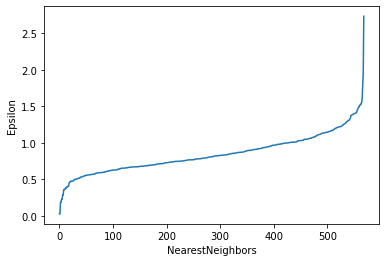

In [9]:
#Finds the optimal value of the epsilon parameter by computing the distance between each point and its two nearest neighbours.
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.xlabel("NearestNeighbors")
plt.ylabel("Epsilon")
plt.plot(distances)

In [10]:
#Defin variables for plotting.
x_axis = []
y_axis_ss = []
y_axis_nmi = []
silhouette_score_std = []
nmi_scores_std = []
corePointsLength, nonCorePointsLength = 0, 0

In [11]:
#isInsideCircle() Function : Calculates the euclidean distance between two points.
def isInsideCircle(center_x, center_y, radius, x, y):
    dist = math.sqrt((x - center_x)**2 + (y - center_y)**2)
    if dist <= radius:
        return True
    else:
        return False

#corePoints() Function : Identifies the core and non-core points in the dataset. 
def corePoints(X, eps, min_samples):
    corePointsList = []
    nonCorePointsList = []
    for i in range(0, len(X)):
        count = 0
        for j in range(0, len(X)):
            if(isInsideCircle(X[i][0], X[i][1], eps, X[j][0], X[j][1])):
                count+=1
            if(count>=min_samples):
                temp = list(X[i])
                temp.append(i)
                corePointsList.append(np.array(temp))
                break
        if(count < min_samples):
            np.append(X[i], i)
            nonCorePointsList.append(X[i])
    return corePointsList, nonCorePointsList

#dbscanfromscratch() Function : Performs the actual DBScan Clustering Algorithm returning the clusters. 
def dbscanfromscratch(X, eps, min_samples):        
    core_points, non_core_points = corePoints(X, eps, min_samples)
    d = {}
    clusterNumber = 0
    while(clusterNumber < 2):
        index = random.randint(0, len(core_points)-1)
        d[clusterNumber] = []
        d[clusterNumber].append(list((core_points[index])))
        center = core_points.pop(index)
        queue = []
        core_points_dup = core_points.copy()
        offset = 0
        for i in range(0, len(core_points_dup)):
            if(isInsideCircle(center[0], center[1], eps, core_points_dup[i][0], core_points_dup[i][1])):
                d[clusterNumber].append(list(core_points_dup[i]))
                queue.append(core_points.pop(i-offset))
                offset += 1
        k = 0
        while(queue and k < 569):
            center =  queue.pop(0)
            core_points_dup = core_points.copy()
            offset = 0
            for i in range(0, len(core_points_dup)):
                if(isInsideCircle(center[0], center[1], eps, core_points_dup[i][0], core_points_dup[i][1])):
                    d[clusterNumber].append(list(core_points_dup[i]))
                    queue.append(core_points.pop(i-offset))
                    offset += 1
            k+=1
        non_core_points_dup = non_core_points.copy()
        offset = 0
        for i in d[clusterNumber]:
            center = i
            for j in range(0, len(non_core_points_dup)):  
                if(isInsideCircle(center[0], center[1], eps, non_core_points_dup[j][0], non_core_points_dup[j][1])):
                    d[clusterNumber].append(list(non_core_points_dup[j]))
                    if(j-offset >= 0 and j-offset < len(non_core_points)):
                        non_core_points.pop(j-offset)
                        offset += 1
        clusterNumber += 1
    
    dbs_pred = []
    for i in range(0, len(X)):
        dbs_pred.append(0)
    for i in d.get(1):
        dbs_pred[int(i[2])] = 1
    return dbs_pred

In [12]:
#Defining variables for error bars and consolidated output.
silhouette_list = []
silhouette_std_list = []
nmi_list = []
nmi_std_list = []
min_samples_list = [0, 1, 2]
eps = 1.75

In [13]:
# Perform cross-validation
for min_sample in min_samples_list:
    silhouette_scores = []
    nmi_scores = []
    
    for i in range(0, 10):
        y_pred = dbscanfromscratch(X, eps, min_sample)

        # Compute the silhouette score and NMI score
        silhouette_scores.append(silhouette_score(X, y_pred))
        nmi_scores.append(normalized_mutual_info_score(y, y_pred))
            
    silhouette_list.append(np.mean(silhouette_scores))
    nmi_list.append(np.mean(nmi_scores))
    
    #Appeding standard deviation for silhouette score and nmi score for the given min_samples
    silhouette_std_list.append(np.std(silhouette_scores))
    nmi_std_list.append(np.std(nmi_scores))

best_min_sample_value = min_samples_list[nmi_list.index(max(nmi_list))]

print("Best min sample value after cross-validation is:", best_min_sample_value)
print("Average Silhouette score", max(silhouette_list))
print("Average NMI score", max(nmi_list))

Best min sample value after cross-validation is: 2
Average Silhouette score 0.51093435
Average NMI score 0.5094163242200344


In [14]:
#Defining the DBScan clustering algorithm
eps = 1.75
min_samples = best_min_sample_value

#DBScan Function call
dbs_pred = dbscanfromscratch(X, eps, min_samples)
print("Silhouette Score:", silhouette_score(X, dbs_pred))
print("NMI Score:", normalized_mutual_info_score(y, dbs_pred))

Silhouette Score: 0.5120174
NMI Score: 0.5120220519232561


Text(0.5, 1.0, 'Actual\xa0clusters')

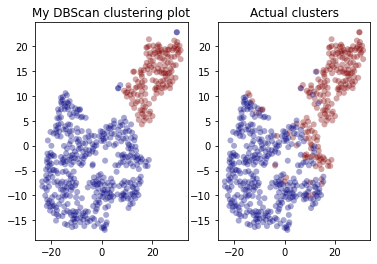

In [15]:
#Labeled scatter plot comapring actual and my cluster
f, (ax1,ax2) = plt.subplots(1, 2)

ax1.scatter(X[:,0],X[:,1],  c=dbs_pred, cmap = "jet", edgecolor = "None", alpha=0.35)
ax1.set_title('My DBScan clustering plot')

ax2.scatter(X[:,0],X[:,1],  c = y, cmap = "jet", edgecolor = "None", alpha=0.35)
ax2.set_title('Actual clusters')

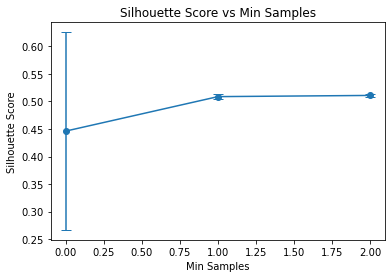

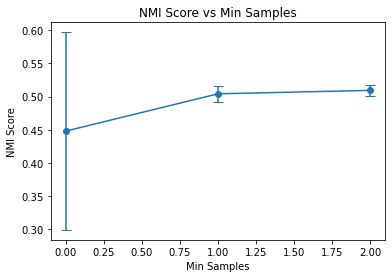

In [16]:
# create line plot with error bars
plt.errorbar(min_samples_list, silhouette_list, yerr=silhouette_std_list,fmt='o-', capsize=5)

# set axis labels and title
plt.xlabel('Min Samples')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Min Samples')

# display plot
plt.show()

# create line plot with error bars
plt.errorbar(min_samples_list, nmi_list, yerr=nmi_std_list,fmt='o-', capsize=5)

# set axis labels and title
plt.xlabel('Min Samples')
plt.ylabel('NMI Score')
plt.title('NMI Score vs Min Samples')

# display plot
plt.show()